In [1]:
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdchem
from qcalc.workers import computeCharges
from qcalc.util.rdkitUtils import extractCharges

In [2]:
# load atomic params
PARAMPATH = "/home/alzbetak/Documents/projects/eem/CombiFF_saturated_haloalkanes_v1.0/scr/inp/"
params = pd.read_csv(PARAMPATH + "prm_7.dat", delim_whitespace=True)
params = params.rename(columns={"#atnm": "atom", "sig": "diameter", "hrd": "hardness", "eln": "electronegativity"})

# fill in some missing data
vdwRadii = {"C": 0.17, "Cl": 0.175, "F": 0.147, "Br": 0.185, "I": 0.198} # 2B verified

params.loc[params["atom"].str.startswith("CH") | params["atom"].str.startswith("CX"), "diameter"] = vdwRadii["C"]
for hal in ["F", "Cl", "Br", "I"]:
    params.loc[params["atom"] == hal, "diameter"] = vdwRadii[hal]

# dummy hardness and electronegativity for CHn
params.loc[params["atom"].str.startswith("CH"), "hardness"] = 10.0
params.loc[params["atom"].str.startswith("CH"), "electronegativity"] = 6.0
params

,atom,iac,mass,diameter,eps,hardness,electronegativity
0,CH0,13,12,0.170,0.000000,10.00000,6.00000
1,CH1,14,3,0.170,0.000000,10.00000,6.00000
2,CH2,15,4,0.170,0.000000,10.00000,6.00000
3,CH3,16,5,0.170,0.000000,10.00000,6.00000
4,CX4,67,12,0.170,0.006109,6.36747,5.96764
5,CX3,68,3,0.170,0.096146,7.92332,5.87687
6,CX2,69,4,0.170,0.440980,9.98845,6.33650
7,CX1,70,5,0.170,1.098306,12.79086,7.95720
8,F,71,19,0.147,0.697460,35.50866,18.71912
9,Cl,72,35,0.175,1.437321,24.45097,14.51889


In [3]:
# make (initial) bond params from atomic data
bondParams = pd.DataFrame(columns=["type", "hardness", "electronegativity"])

meanBondProps = dict()

for prop in ["hardness", "electronegativity"]:
    meanBondProps[prop] = dict()
    for atom in ["CH", "CX", "F", "Cl", "Br", "I"]:
        meanBondProps[prop][atom] = params.loc[params["atom"].str.startswith(atom)][prop].mean()

# C-C bonds
bondParams = bondParams.append({'type': 'C-C', 'hardness': 0.5*(meanBondProps["hardness"]["CH"] + meanBondProps["hardness"]["CX"]), \
                               'electronegativity': 0.5*(meanBondProps["electronegativity"]["CH"] + meanBondProps["electronegativity"]["CX"])}, \
                               ignore_index = True)

# C-X bonds
for hal in ["F", "Cl", "Br", "I"]:
    bondParams = bondParams.append({'type': 'C-' + hal, 'hardness': 0.5*(meanBondProps["hardness"]["CX"] + meanBondProps["hardness"][hal]), \
                               'electronegativity': 0.5*(meanBondProps["electronegativity"]["CX"] + meanBondProps["electronegativity"][hal])}, \
                                   ignore_index = True)
    
bondParams

,type,hardness,electronegativity
0,C-C,9.633762,6.267276
1,C-F,22.388092,12.626836
2,C-Cl,16.859248,10.526721
3,C-Br,15.696722,9.751226
4,C-I,13.957287,8.940586


In [4]:
# load molecules with DDEC charges
DDECPATH = "/home/alzbetak/Documents/projects/eem/ddec_sdf/"
moleculesD = dict()
ddecCharges = dict()

for f in os.listdir(DDECPATH):
    mol = Chem.MolFromMolFile(DDECPATH + f, removeHs=False)
    m = Chem.RemoveHs(mol)
    smiles = Chem.MolToSmiles(m, isomericSmiles=False)
    ddecCharges[smiles] = extractCharges(mol)
    moleculesD[smiles] = m

In [5]:
# load molecules with Marina's charges
MPATH = "/home/alzbetak/Documents/projects/eem/CombiFF_saturated_haloalkanes_v1.0/scr/sdf/"
moleculesM = dict()
chargesM = dict()

for f in os.listdir(MPATH):
    mol = Chem.MolFromMolFile(MPATH + f, removeHs=False)
    m = Chem.RemoveHs(mol)
    smiles = Chem.MolToSmiles(m, isomericSmiles=False)
    chargesM[smiles] = extractCharges(mol)
    moleculesM[smiles] = m

RDKit WARNING: [20:08:58] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [20:08:58] Warning: molecule is tagged as 3D, but all Z coords are zero
RDKit WARNING: [20:08:58] Warning: molecule is tagged as 3D, but all Z coords are zero


In [6]:
def atomType(atom, mol):
    halogens = ["F", "Cl", "Br", "I"]
    symbol = atom.GetSymbol()
    if symbol in halogens:
        return symbol
    elif symbol == "C":
        haloNeighbors = [a for a in atom.GetNeighbors() if a.GetSymbol() in halogens]
        numHaloNeighbors = len(haloNeighbors)
        if numHaloNeighbors > 0:
            return "CX" + str(numHaloNeighbors)
        else:
            carbNeighbors = [a for a in atom.GetNeighbors() if a.GetSymbol() == "C"]
            numCarbNeighbors = len(carbNeighbors)
            return "CH" + str(4 - numCarbNeighbors)
    else:
        return None

In [7]:
def bondType(bond, mol):
    b1 = bond.GetBeginAtom().GetSymbol()
    b2 = bond.GetEndAtom().GetSymbol()
    if b1 == "H" or b2 == "H":
        return None
    else:
        if b1 != "C":
            b1, b2 = b2, b1
        return b1 + "-" + b2

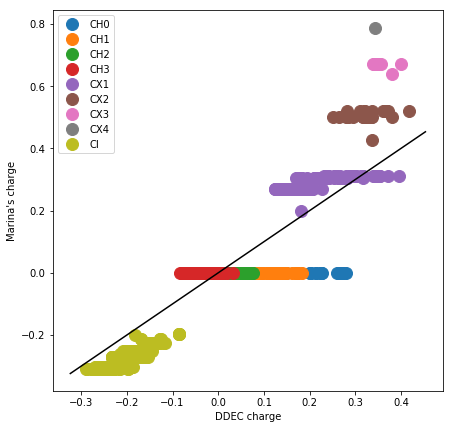

In [9]:
import matplotlib.pyplot as plt

charges = pd.DataFrame(columns = ["smiles", "atom", "DDEC", "Marina", "numc"])

for smiles, mol in moleculesD.items():
    for i, atom in enumerate(mol.GetAtoms()):
        charges = charges.append({'smiles': smiles, 'atom': atomType(atom, mol), 'DDEC': ddecCharges[smiles][i], \
                          'Marina': chargesM[smiles][i]}, ignore_index=True)
        
# group according to atom type
groups = charges.groupby("atom")

fig, ax = plt.subplots(figsize=(7,7))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.DDEC, group.Marina, marker='o', linestyle='', ms=12, label=name)
ax.legend()
ax.set_xlabel("DDEC charge")
ax.set_ylabel("Marina's charge")
ax.plot()
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, color="k")

plt.show()

In [10]:
# mock EEM
# initialize new cols
charges["EEM"] = 0

for smiles, mol in moleculesD.items():
    molCharges = computeCharges(mol, params, "EEM", atomType, maxOrder=2)
    charges.loc[charges['smiles'] == smiles, 'EEM'] = molCharges

In [11]:
# mock AACT
# initialize new cols
charges["AACT"] = 0

for smiles, mol in moleculesD.items():
    molCharges = computeCharges(mol, params, "AACT", atomType, bondTypeFunc=bondType, bondParamTable=bondParams, maxOrder=2)
    charges.loc[charges['smiles'] == smiles, 'AACT'] = molCharges

In [12]:
# mock SQE
# initialize new cols
charges["SQE"] = 0

for smiles, mol in moleculesD.items():
    molCharges = computeCharges(mol, params, "SQE", atomType, bondTypeFunc=bondType, bondParamTable=bondParams, kappa=1,lam=1, maxOrder=2)
    charges.loc[charges['smiles'] == smiles, 'SQE'] = molCharges

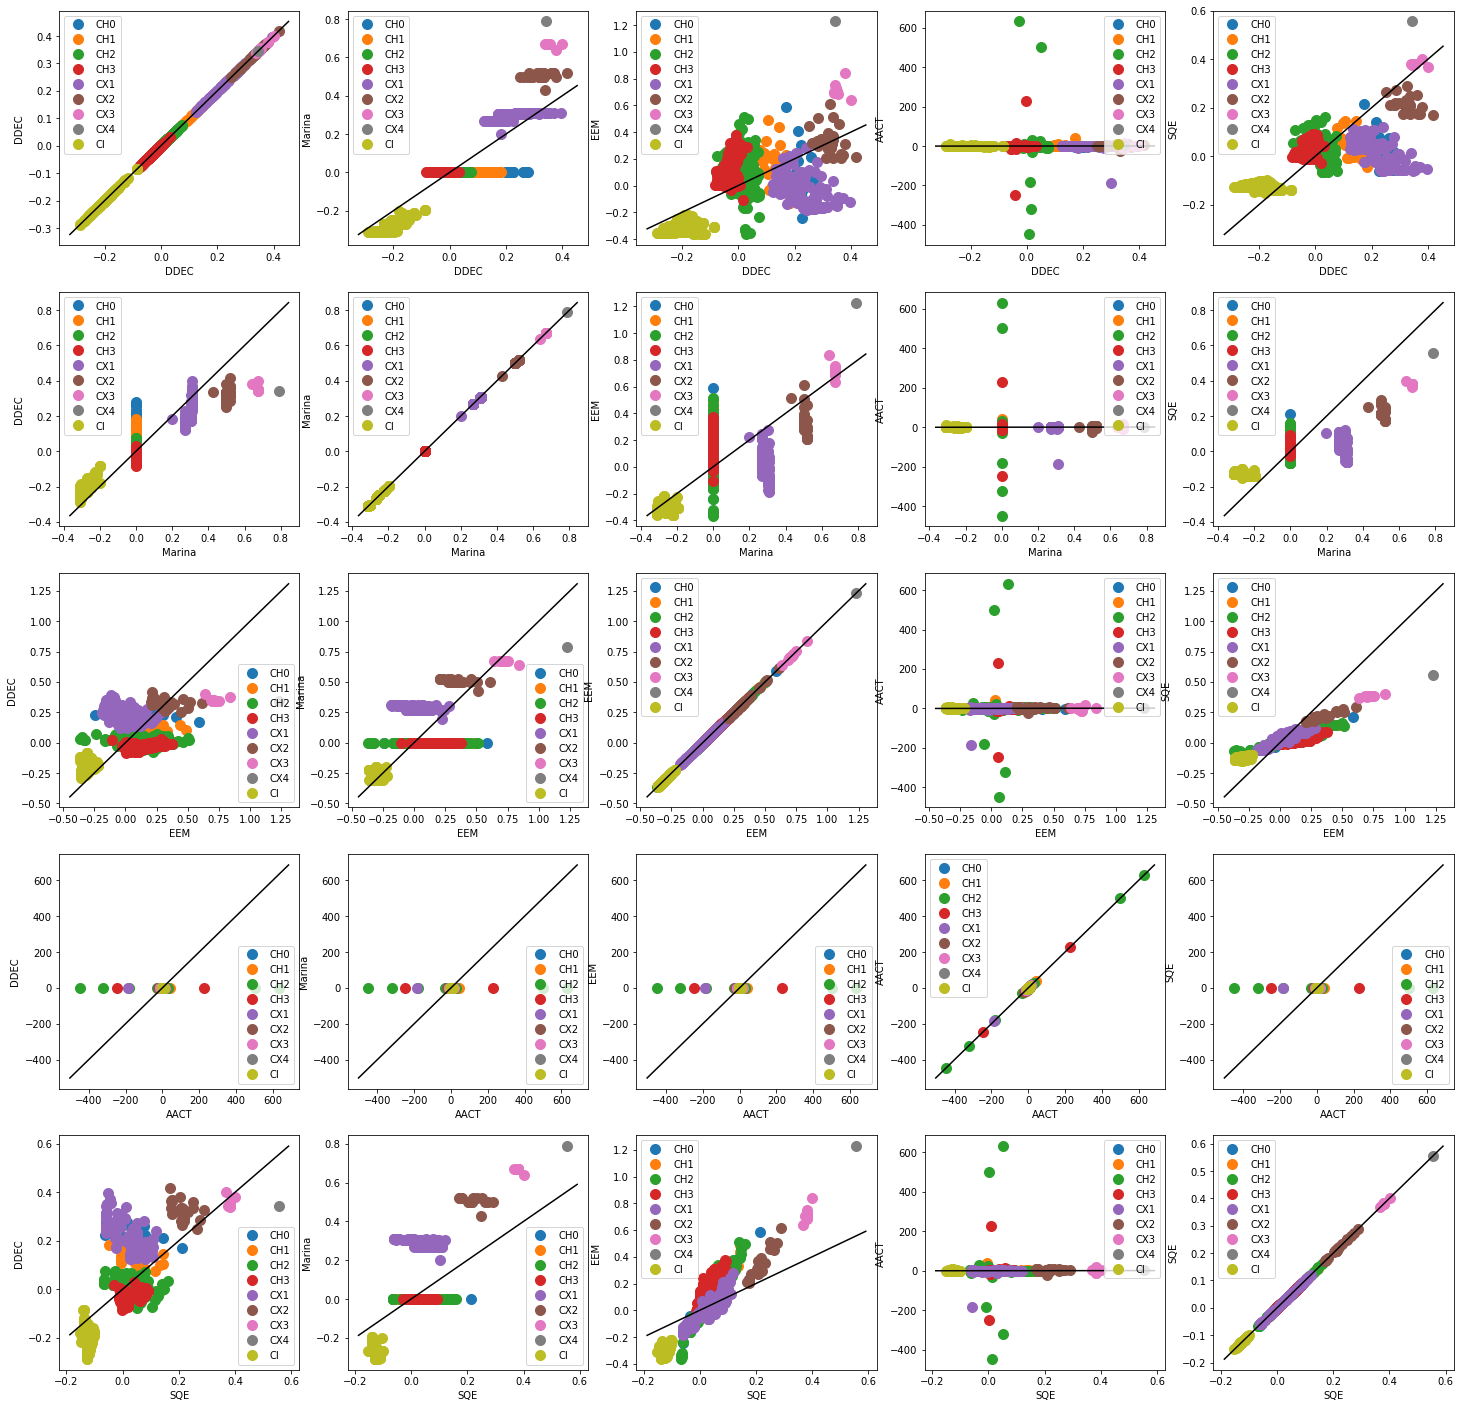

In [13]:
fig, ax = plt.subplots(5, 5, figsize=(25,25))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

combinations = ['DDEC', 'Marina', 'EEM', 'AACT', 'SQE']

for i,prim in enumerate(combinations):
     for j,sec in enumerate(combinations):
        for name, group in groups:
            ax[i,j].plot(group[prim], group[sec], marker='o', linestyle='', ms=10, label=name)
        ax[i,j].set_xlabel(prim)
        ax[i,j].set_ylabel(sec)
        xpoints = ypoints = ax[i,j].get_xlim()
        ax[i,j].plot(xpoints, ypoints, color="k")
        ax[i,j].legend(loc="best")

plt.show()

In [59]:
from collections import defaultdict

def numCarbons(mol):
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    return atoms.count("C")

charges["numc"] = charges.apply(lambda row: numCarbons(moleculesD[row.smiles]), axis = 1)
charges["set"] = charges.apply(lambda row: "train" if row.numc <=6 else "test", axis=1)

atomCounts = defaultdict(int)
atomCounts.update({n:len(g) for n,g in charges.groupby("atom")})
params["count"] = params["atom"].map(atomCounts)

In [8]:
def numCarbons(mol):
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    return atoms.count("C")

molecules = []
targetCharges = []

# make training and test set
for smiles, mol in moleculesD.items():
    smiles_C = smiles.replace("Cl", "")
    count_C = smiles_C.count("C")
    if numCarbons(mol) <= 6:
        molecules.append(mol)
        targetCharges.append(ddecCharges[smiles])

# remove atom/bond types which are not in the data set
paramsFiltered = params[~params["atom"].isin(["F", "Br", "I"])]
bondParamsFiltered = bondParams[bondParams['type'].isin(["C-C", "C-Cl"])]

paramsFiltered = paramsFiltered.reset_index(drop=True)
bondParamsFiltered = bondParamsFiltered.reset_index(drop=True)

paramsFiltered.loc[paramsFiltered["atom"] == "Cl", "electronegativity"] = 3.0

In [ ]:
charges.merge(params, left_on="atom")

In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt

count_C_histogram = dict()

for smiles,mol in moleculesD.items():
    smiles_C = smiles.replace("Cl", "")
    count_C = smiles_C.count("C")
    atomTypes = [atomType(a, mol) for a in mol.GetAtoms()]
    for a in atomTypes:
        if a not in count_C_histogram:
            count_C_histogram[a] = defaultdict(int)
        count_C_histogram[a][count_C] += 1
        
x = y = {}
bottom = defaultdict()
for a,count in count_C_histogram.items():
    x[a] = sorted(count_C_histogram[a])
    y[a] = [count_C_histogram[a][c] for c in x]
    bottom[a] = [b+c for b,c in zip(count_C_histogram[a], bottom[a])]
    

#plt.bar(x,y)
#plt.xlabel("number of carbons")
#plt.ylabel("number of molecules in dataset")
#plt.show()

In [9]:
from qcalc.optimize import calculateWeights, costFunction, createParamsArr, createWorkers, updateParams
from qcalc.workers import createParameters

method = "EEM"

p, bp = createParameters(paramsFiltered, method, bondParamTable=bondParamsFiltered)
#p.addConstraint("Cl", "electronegativity")
#bp.addConstraint("C-C", "hardness", id="type")
paramsArr, constr = createParamsArr(p, bp)
workers = createWorkers(molecules, p, method, atomType, bp, maxOrder=2, bondTypeFunc=bondType)
atomTypes = [a for w in workers for a in w.atomTypes]
weights = calculateWeights(atomTypes, p)

hardnessLowerBounds = np.array(1./(np.pi * np.sqrt(2) * p.df["diameter"]))
lowerBounds = (p.N-len(p.constraints))*[0.001] + hardnessLowerBounds.tolist()
ranges = [(lb,10*pa) for pa, lb in zip(paramsArr, lowerBounds)]
cost = costFunction(paramsArr, workers, weights, targetCharges, constr)

In [10]:
cost

6.813397340694608

In [28]:
p.df

,atom,iac,mass,diameter,eps,hardness,electronegativity,weights
0,CH0,13,12,0.170,0.000000,610.716266,48.911076,0.377964
1,CH1,14,3,0.170,0.000000,444.128159,47.380586,0.204124
2,CH2,15,4,0.170,0.000000,1.093749,0.001000,0.094916
3,CH3,16,5,0.170,0.000000,1000.000000,34.112467,0.077382
4,CX4,67,12,0.170,0.006109,151.641890,133.934245,1.000000
5,CX3,68,3,0.170,0.096146,194.552522,98.871948,0.408248
6,CX2,69,4,0.170,0.440980,163.797214,101.375041,0.196116
7,CX1,70,5,0.170,1.098306,969.741665,0.001000,0.090536
8,Cl,72,35,0.175,1.437321,933.970356,3.000000,0.071429


In [11]:
from scipy.optimize import dual_annealing, differential_evolution

#opt = dual_annealing(costFunction, ranges, args=(workers, weights, targetCharges, constr), maxiter=100, seed=234567)
opt = differential_evolution(costFunction, ranges, args=(workers, weights, targetCharges, constr), popsize=100, updating="deferred", \
                             init="random", seed=1331, workers=-1)
updateParams(p, bp, opt.x)

In [12]:
p.df

,atom,iac,mass,diameter,eps,hardness,electronegativity,weights
0,CH0,13,12,0.170,0.000000,64.226059,0.001000,0.377964
1,CH1,14,3,0.170,0.000000,100.000000,2.016122,0.204124
2,CH2,15,4,0.170,0.000000,100.000000,13.023816,0.094916
3,CH3,16,5,0.170,0.000000,100.000000,18.012965,0.077382
4,CX4,67,12,0.170,0.006109,46.358198,9.203288,1.000000
5,CX3,68,3,0.170,0.096146,51.530650,2.086597,0.408248
6,CX2,69,4,0.170,0.440980,45.835675,2.443862,0.196116
7,CX1,70,5,0.170,1.098306,23.008281,10.643797,0.090536
8,Cl,72,35,0.175,1.437321,78.740856,30.000000,0.071429


In [32]:
opt

     fun: 0.06705019234592134
     jac: array([ 1.06112341e-04,  7.53147549e-06,  1.10467182e-06, -1.47104539e-06,
        7.23032685e-06,  7.98389137e-06,  5.89250874e-06,  2.72004619e-06,
       -1.37105593e-04, -1.48492423e-06, -1.20445396e-05, -2.08305726e-05,
       -1.37501208e-05,  2.48412381e-06, -1.82909228e-06,  6.50868194e-07,
        1.82909228e-06,  2.70617032e-06])
 message: 'Optimization terminated successfully.'
    nfev: 611264
     nit: 338
 success: True
       x: array([1.00000000e-03, 2.01612182e+00, 1.30238164e+01, 1.80129650e+01,
       9.20328766e+00, 2.08659683e+00, 2.44386245e+00, 1.06437968e+01,
       3.00000000e+01, 6.42260586e+01, 1.00000000e+02, 1.00000000e+02,
       1.00000000e+02, 4.63581981e+01, 5.15306499e+01, 4.58356753e+01,
       2.30082806e+01, 7.87408564e+01])

In [92]:
opt

     fun: 0.07771204359859697
 message: ['Maximum number of iteration reached']
    nfev: 4931
    nhev: 0
     nit: 100
    njev: 70
  status: 0
 success: True
       x: array([ 3893.0806295 ,  4714.90642432,  5241.44003165,  5676.41833953,
        5802.27020976,  4287.22828407,  3239.27129494,  2864.38935904,
        8153.45848936,  6168.411152  ,  5318.64606757,  9991.43503058,
        9813.0035809 ,  4061.59339959,  5364.73034599,  7788.8058034 ,
       12494.76771126, 14164.80147156])

In [14]:
p.update(opt.x)
optParams = p.df

charges = pd.DataFrame(columns = ["smiles", "atom", "set", "numc", "DDEC", "Marina", "optEEM"])

for smiles, mol in moleculesD.items():
    for i, atom in enumerate(mol.GetAtoms()):
        charges = charges.append({'smiles': smiles, 'atom': atomType(atom, mol), 'DDEC': ddecCharges[smiles][i], \
                          'Marina': chargesM[smiles][i]}, ignore_index=True)
        
# group according to atom type
groups = charges.groupby("atom")

# mock EEM
# initialize new cols
charges["optEEM"] = 0

for smiles, mol in moleculesD.items():
    molCharges = computeCharges(mol, optParams, "EEM", atomType, maxOrder=2)
    charges.loc[charges['smiles'] == smiles, 'optEEM'] = molCharges
    
def numCarbons(mol):
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    return atoms.count("C")

charges["numc"] = charges.apply(lambda row: numCarbons(moleculesD[row.smiles]), axis = 1)
charges["set"] = charges.apply(lambda row: "train" if row.numc <=6 else "test", axis=1)

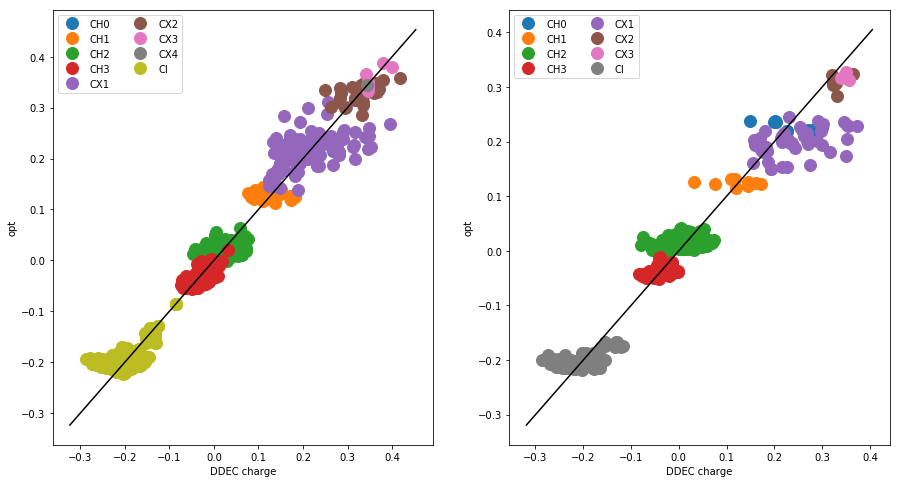

In [15]:
import matplotlib.pyplot as plt

charges_train = charges[charges["set"] == "train"]
charges_test = charges[charges["set"] == "test"]

groups_train = charges_train.groupby("atom")
groups_test = charges_test.groupby("atom")

fig, ax = plt.subplots(1,2, figsize=(15,8))
#ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for axp,series in enumerate([groups_train, groups_test]):
    for name, group in series:
        ax[axp].plot(group.DDEC, group.optEEM, marker='o', linestyle='', ms=12, label=name)
    
for axp in [0,1]:
    ax[axp].legend(ncol=2)
    ax[axp].set_xlabel("DDEC charge")
    ax[axp].set_ylabel("opt")
    ax[axp].plot()
    xpoints = ypoints = ax[axp].get_xlim()
    ax[axp].plot(xpoints, ypoints, color="k")

plt.show()

In [97]:
optParams

,atom,iac,mass,diameter,eps,hardness,electronegativity,weights
0,CH0,13,12,0.170,0.000000,6168.411152,3893.080629,0.377964
1,CH1,14,3,0.170,0.000000,5318.646068,4714.906424,0.204124
2,CH2,15,4,0.170,0.000000,9991.435031,5241.440032,0.094916
3,CH3,16,5,0.170,0.000000,9813.003581,5676.418340,0.077382
4,CX4,67,12,0.170,0.006109,4061.593400,5802.270210,1.000000
5,CX3,68,3,0.170,0.096146,5364.730346,4287.228284,0.408248
6,CX2,69,4,0.170,0.440980,7788.805803,3239.271295,0.196116
7,CX1,70,5,0.170,1.098306,12494.767711,2864.389359,0.090536
8,Cl,72,35,0.175,1.437321,14164.801472,8153.458489,0.071429


In [9]:
from qcalc.optimize import optimizeParameters, costFunction

workers, paramsArr, weights = optimizeParameters(molecules, paramsFiltered, "EEM", atomType, targetCharges)

In [11]:
len(paramsArr)

18

In [12]:
from scipy.optimize import dual_annealing, shgo

ranges = [(1E-3,10*p) for p in paramsArr]

dual_annealing(costFunction, ranges, args=(workers, weights, targetCharges), maxiter=10)

     fun: 0.04725223524387449
 message: ['Maximum number of iteration reached']
    nfev: 2641
    nhev: 0
     nit: 10
    njev: 120
  status: 0
 success: True
       x: array([15.54819531, 17.97801656, 23.79414817, 27.14641738, 22.87499851,
        1.95297352, 22.36826872, 22.90315928, 32.62751152, 41.7763538 ,
       54.80144609, 66.34110343, 46.84237832, 27.04041911, 78.53452265,
       17.38468753, 15.93529537, 36.75529206])

In [15]:
dual_annealing(costFunction, ranges, args=(workers, weights, targetCharges), maxiter=10, seed=234567)

     fun: 0.047067650690184024
 message: ['Maximum number of iteration reached']
    nfev: 5016
    nhev: 0
     nit: 10
    njev: 245
  status: 0
 success: True
       x: array([28.49677712, 27.93291003, 35.30105471, 38.42553391, 25.4465218 ,
       19.74219292, 33.64860984, 34.2022305 , 43.49828782, 34.89658145,
       65.32389624, 55.56269562, 46.10119355, 51.79102155, 60.31466307,
       17.46536442, 16.07888671, 34.51602385])

In [14]:
dual_annealing(costFunction, ranges, args=(workers, weights, targetCharges), maxiter=20, seed=12345)

     fun: 0.047485410994994405
 message: ['Maximum number of iteration reached']
    nfev: 3343
    nhev: 0
     nit: 20
    njev: 138
  status: 0
 success: True
       x: array([30.86970586, 28.54231707, 35.77560479, 39.72858935, 27.30702103,
       16.60056887, 32.84689142, 34.64183185, 44.99125022, 26.09836804,
       64.40495049, 60.07820407, 67.70691814, 49.48306173, 71.25285795,
       21.59358961, 16.32721265, 39.46131656])

In [10]:
opt

     fun: 0.04664671418637992
 message: ['Maximum number of iteration reached']
    nfev: 6081
    nhev: 0
     nit: 10
    njev: 224
  status: 0
 success: True
       x: array([ 34.80749453,  37.4692473 ,  40.83862802,  43.7746412 ,
        31.04427792,  21.3331578 ,  39.2513488 ,  39.74674598,
        59.40453849,  48.94565548,  91.20015387,   7.62477499,
        31.13117433,  33.51216547,  49.44399721,  44.27322016,
        51.24955065,  70.69839506,  16.81796389,  15.59519469,
       264.88110354,  34.75124336,  62.83354146, 146.77466306])

In [11]:
params

,atom,iac,mass,diameter,eps,hardness,electronegativity,weights
0,CH0,13,12,0.170,0.000000,10.00000,6.00000,0.377964
1,CH1,14,3,0.170,0.000000,10.00000,6.00000,0.204124
2,CH2,15,4,0.170,0.000000,10.00000,6.00000,0.094916
3,CH3,16,5,0.170,0.000000,10.00000,6.00000,0.077382
4,CX4,67,12,0.170,0.006109,6.36747,5.96764,1.000000
5,CX3,68,3,0.170,0.096146,7.92332,5.87687,0.408248
6,CX2,69,4,0.170,0.440980,9.98845,6.33650,0.196116
7,CX1,70,5,0.170,1.098306,12.79086,7.95720,0.090536
8,F,71,19,0.147,0.697460,35.50866,18.71912,0.000000
9,Cl,72,35,0.175,1.437321,24.45097,14.51889,0.071429


In [54]:
from qcalc.optimize import optimizeParameters

workers, params_object, atomTypes, weights, cost = optimizeParameters(molecules, params, "QeqAtomic", atomType, targetCharges, bondParamTable=bondParams, \
                                                                     bondTypeFunc = bondType, kappa=1, lam=1)

In [55]:
cost

6.4322043410761705